In [38]:
! pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 75 kB 25 kB/s  eta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [63]:
pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 121 kB 924 kB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 342 kB/s eta 0:00:01
     |████████████████████████████████| 243 kB 225 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [64]:
import torch


In [3]:
!ls


Untitled.ipynb


In [3]:
!pip3 install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html



Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 169.1 MB 24 kB/s  eta 0:00:01   |                                | 542 kB 159 kB/s eta 0:17:40     |██                              | 10.2 MB 208 kB/s eta 0:12:44     |██████████████                  | 74.3 MB 117 kB/s eta 0:13:30
     |████████████████████████████████| 13.3 MB 201 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 76 kB/s eta 0:00:011
     |████████████████████████████████| 14.8 MB 166 kB/s eta 0:00:01


In [7]:
!pip install torchvision

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe927a15c50>: Failed to establish a new connection: [Errno 111] Connection refused',)': /packages/a8/68/627a2f02233aa7c26590336e92c7859d196ca0e870d0875041d6ef3df516/torchvision-0.5.0-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 4.0MB 58kB/s ta 0:00:0111
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 17.0MB 51kB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/packages/46/ca/306bb933a68b888ab1c20ede0342506b85857635f04fb55a56e53065579b/torch-1.4.0-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 2.1MB 95kB/s eta 0:00:011


In [26]:
import torchvision
import torch
from torch import nn
from torchvision import transforms
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from PIL import Image
from torchvision.datasets import MNIST
import pandas as pd
import numpy as np

import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, transform



def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MalayalamDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.csv_frame.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.csv_frame.iloc[idx, 1:]
        label = torch.tensor(int(self.csv_frame.iloc[idx,1]))

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
#DATA_DIR = '../ML/dataset/'

image_size = 64
batch_size = 128
stats = (0.5,), (0.5,)


dataset = MalayalamDataset(csv_file='letters.csv', root_dir='',transform = tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        ]))

In [27]:
#generator
class Generator(nn.Module):
   
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    
        if not final_layer:
            return nn.Sequential(
              
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            
            ) 
        else:
            return nn.Sequential(
                
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
    
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device= device)
   

In [28]:
 #UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [29]:
try:
    assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
    assert hidden_output.max() > 1
    assert hidden_output.min() == 0
    assert hidden_output.std() > 0.2
    assert hidden_output.std() < 1
    assert hidden_output.std() > 0.5

    assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

    assert final_output.max().item() == 1
    assert final_output.min().item() == -1

    assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
    assert gen_output.std() > 0.5
    assert gen_output.std() < 0.8
    print("Success!")
except: 
    print("Some of asserts have fail")


Success!


In [30]:
class Discriminator(nn.Module):
    
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )
        
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
       
      
        if not final_layer:
            return nn.Sequential(
               
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                
            )
        else:
            return nn.Sequential(
                
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                
            )
        
    def forward(self, image):
            disc_pred = self.disc(image)
            return disc_pred.view(len(disc_pred), -1)

In [31]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [32]:
try:
    # Test the hidden block
    assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
    # Because of the LeakyReLU slope
    assert -hidden_output.min() / hidden_output.max() > 0.15
    assert -hidden_output.min() / hidden_output.max() < 0.25
    assert hidden_output.std() > 0.5
    assert hidden_output.std() < 1

    # Test the final block

    assert tuple(final_output.shape) == (num_test, 10, 6, 6)
    assert final_output.max() > 1.0
    assert final_output.min() < -1.0
    assert final_output.std() > 0.3
    assert final_output.std() < 0.6

    # Test the whole thing:

    assert tuple(disc_output.shape) == (num_test, 1)
    assert disc_output.std() > 0.25
    assert disc_output.std() < 0.5
    print("Success!")
except:
    print("Some of asserts have fail")

Success!


In [35]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128

lr = 0.0002

beta_1 = 0.5 
beta_2 = 0.999
device = 'cpu'


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    ,
    batch_size=batch_size,
    shuffle=True)

transform = transforms.Compose([
    transforms.ToTensor,
    transforms.Normalize((0.5,), (0.5,)),
])
 

In [36]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)



  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.9441561905741686, discriminator loss: 0.511606013804674


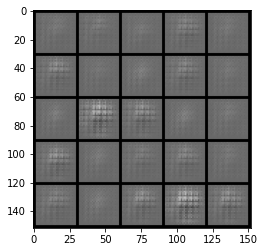

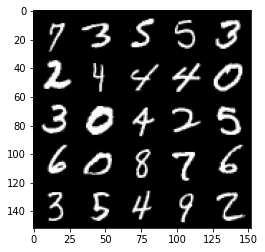

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1